# Pull Additional WRDS Data for Heston Calibration

This notebook pulls:
1. **Zero Curve** (`zerocd`) - Risk-free rates by days to maturity
2. **Standard Option Prices** (`stdopd`) - Standard option prices with forward prices

**Prerequisites:**
- WRDS account with OptionMetrics access
- Run `DataGetter.ipynb` first to get volatility surface data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import wrds

# -------------------
# USER CONFIG
# -------------------
WRDS_USERNAME = "acaraman"
LIB = "optionm"

TICKER = "AAPL"
START_DATE = "2016-01-01"
END_DATE = "2025-12-31"

YEARS = list(range(int(START_DATE[:4]), int(END_DATE[:4]) + 1))

# -------------------
# OUTPUT PATHS
# -------------------
RAW_DIR = Path("../../data/raw/ivydb")
RAW_DIR.mkdir(parents=True, exist_ok=True)

# Ensure subdirectories exist
(RAW_DIR / "zero_curve").mkdir(parents=True, exist_ok=True)
(RAW_DIR / "std_option_price").mkdir(parents=True, exist_ok=True)

print("Output directories:")
print(f"  Zero curve:       {(RAW_DIR / 'zero_curve').resolve()}")
print(f"  Std option price: {(RAW_DIR / 'std_option_price').resolve()}")

Output directories:
  Zero curve:       C:\Users\Admin\OneDrive\Desktop\Fifth Year\Computer Science\CS4490 Thesis\Codebase\Thesis\data\raw\ivydb\zero_curve
  Std option price: C:\Users\Admin\OneDrive\Desktop\Fifth Year\Computer Science\CS4490 Thesis\Codebase\Thesis\data\raw\ivydb\std_option_price


In [2]:
# Connect to WRDS
from sqlalchemy import text

try:
    db.close()
except:
    pass

db = wrds.Connection(wrds_username=WRDS_USERNAME)
engine = db.engine
print(f"Connected to WRDS. Engine type: {type(engine)}")

# Test connection
with engine.connect() as conn:
    result = conn.execute(text("SELECT 1 AS test"))
    test_result = pd.DataFrame(result.fetchall(), columns=result.keys())
print(f"Connection test: {test_result['test'].iloc[0]} (should be 1)")

Loading library list...
Done
Connected to WRDS. Engine type: <class 'sqlalchemy.engine.base.Engine'>
Connection test: 1 (should be 1)


In [3]:
# Helper functions
def list_tables(lib=LIB):
    return set(db.list_tables(library=lib))

def describe_cols(table, lib=LIB):
    desc = db.describe_table(library=lib, table=table)
    return desc["name"].tolist(), desc

def pick_col(cols, candidates, required=True):
    cols_l = [c.lower() for c in cols]
    for cand in candidates:
        cand_l = cand.lower()
        if cand_l in cols_l:
            return cols[cols_l.index(cand_l)]
    if required:
        raise KeyError(f"Could not find any of {candidates} in columns: {cols}")
    return None

def has_table(table, lib=LIB):
    return table in list_tables(lib)

def run_query(sql, date_cols=None):
    """Run SQL query using native SQLAlchemy execution."""
    with engine.connect() as conn:
        result = conn.execute(text(sql))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
    if date_cols:
        for col in date_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col])
    return df

print("Helper functions defined.")

Helper functions defined.


## 1. Resolve SECID for Ticker

In [4]:
def resolve_secid(ticker: str, start_date: str, end_date: str) -> int:
    """
    Resolve ticker to SECID using secnmd table.
    Returns the SECID with most volatility surface coverage.
    """
    ticker = ticker.upper()
    
    # Get secids from secnmd
    q = f"""
    SELECT DISTINCT secid
    FROM {LIB}.secnmd
    WHERE ticker = '{ticker}'
    """
    secids = run_query(q)
    
    if secids.empty:
        raise RuntimeError(f"No SECID found for ticker {ticker}")
    
    print(f"Found {len(secids)} SECID(s) for {ticker}: {secids['secid'].tolist()}")
    
    # If multiple, choose one with most surface coverage
    if len(secids) > 1:
        secid_list = ",".join(str(int(x)) for x in secids["secid"].unique())
        
        counts = []
        for y in YEARS:
            t = f"vsurfd{y}"
            if not has_table(t):
                continue
            q = f"""
            SELECT secid, COUNT(DISTINCT date) AS n_days
            FROM {LIB}.{t}
            WHERE secid IN ({secid_list})
              AND date BETWEEN '{start_date}' AND '{end_date}'
            GROUP BY secid
            """
            counts.append(run_query(q))
        
        if counts:
            cov = (pd.concat(counts, ignore_index=True)
                     .groupby("secid", as_index=False)["n_days"].sum()
                     .sort_values("n_days", ascending=False))
            display(cov)
            return int(cov.iloc[0]["secid"])
    
    return int(secids.iloc[0]["secid"])

SECID = resolve_secid(TICKER, START_DATE, END_DATE)
print(f"\nUsing SECID: {SECID}")

Found 1 SECID(s) for AAPL: [101594.0]

Using SECID: 101594


## 2. Pull Zero Curve Data

The zero curve provides risk-free rates by days to maturity. This is **not** security-specific - it's the same for all options on a given date.

In [5]:
# First, let's explore the zero curve table structure
if has_table("zerocd2024"):
    cols, desc = describe_cols("zerocd2024")
    print("zerocd2024 columns:")
    display(desc)
elif has_table("zerocd"):
    cols, desc = describe_cols("zerocd")
    print("zerocd columns:")
    display(desc)
else:
    print("Zero curve tables not found. Available tables:")
    print([t for t in list_tables() if 'zero' in t.lower()])

Approximately 304301 rows in optionm.zerocd.
zerocd columns:


,name,nullable,type,comment
0,date,True,DATE,Date of this Zero Curve
1,days,True,DOUBLE_PRECISION,Days to Maturity
2,rate,True,DOUBLE_PRECISION,Continuously Compounded Zero-Coupon Interest Rate


In [6]:
def pull_zero_curve(start_date: str, end_date: str) -> pd.DataFrame:
    """
    Pull zero curve data from optionm.zerocd (or yearly tables).
    
    Returns DataFrame with columns:
        date, days, rate (continuously compounded)
    """
    frames = []
    
    # Try yearly tables first (zerocdYYYY)
    for y in YEARS:
        t = f"zerocd{y}"
        if not has_table(t):
            continue
        
        print(f"  Pulling from {t}...")
        
        q = f"""
        SELECT date, days, rate
        FROM {LIB}.{t}
        WHERE date BETWEEN '{start_date}' AND '{end_date}'
        """
        df = run_query(q, date_cols=["date"])
        if not df.empty:
            print(f"    -> {len(df):,} rows")
            frames.append(df)
    
    # Fallback to zerocd if yearly tables don't exist
    if not frames and has_table("zerocd"):
        print("  Pulling from zerocd...")
        q = f"""
        SELECT date, days, rate
        FROM {LIB}.zerocd
        WHERE date BETWEEN '{start_date}' AND '{end_date}'
        """
        df = run_query(q, date_cols=["date"])
        if not df.empty:
            frames.append(df)
    
    if not frames:
        raise RuntimeError("Could not pull zero curve data")
    
    zc = pd.concat(frames, ignore_index=True)
    zc = zc.drop_duplicates(subset=["date", "days"]).sort_values(["date", "days"])
    
    return zc

print("Pulling zero curve data...")
zc = pull_zero_curve(START_DATE, END_DATE)
print(f"\nTotal rows: {len(zc):,}")

Pulling zero curve data...
  Pulling from zerocd...

Total rows: 77,707


In [7]:
# Inspect zero curve data
print("Zero Curve Summary:")
print(f"  Date range: {zc['date'].min()} to {zc['date'].max()}")
print(f"  Unique dates: {zc['date'].nunique():,}")
print(f"  Days range: {zc['days'].min()} to {zc['days'].max()}")
print(f"  Unique days: {zc['days'].nunique()}")
print(f"  Rate range: {zc['rate'].min():.4f} to {zc['rate'].max():.4f}")

print("\nSample data:")
display(zc.head(20))

Zero Curve Summary:
  Date range: 2016-01-04 00:00:00 to 2025-08-29 00:00:00
  Unique dates: 2,429
  Days range: 3.0 to 3669.0
  Unique days: 3664
  Rate range: 0.0587 to 5.7935

Sample data:


,date,days,rate
0,2016-01-04,7.0,0.392860
1,2016-01-04,16.0,0.406151
2,2016-01-04,44.0,0.542785
3,2016-01-04,72.0,0.591868
4,2016-01-04,107.0,0.638625
5,2016-01-04,135.0,0.670144
6,2016-01-04,163.0,0.699538
7,2016-01-04,261.0,0.773386
8,2016-01-04,352.0,0.846995
9,2016-01-04,436.0,0.919836


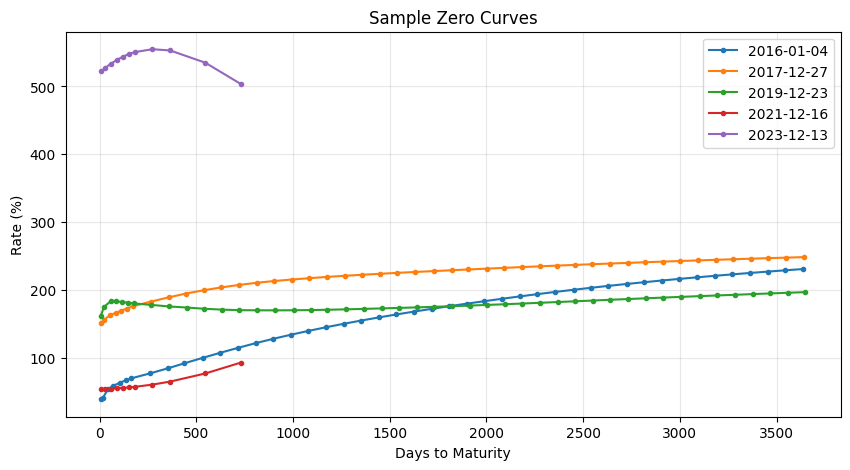

In [8]:
# Plot a few sample days of the zero curve
import matplotlib.pyplot as plt

sample_dates = zc['date'].drop_duplicates().iloc[::500].head(5).tolist()  # Every 500th date

fig, ax = plt.subplots(figsize=(10, 5))
for d in sample_dates:
    curve = zc[zc['date'] == d].sort_values('days')
    ax.plot(curve['days'], curve['rate'] * 100, label=str(d)[:10], marker='o', markersize=3)

ax.set_xlabel('Days to Maturity')
ax.set_ylabel('Rate (%)')
ax.set_title('Sample Zero Curves')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [9]:
# Save zero curve data
zc_path = RAW_DIR / "zero_curve" / f"zero_curve_{START_DATE}_{END_DATE}.csv.gz"
zc.to_csv(zc_path, index=False, compression="gzip")
print(f"Saved zero curve to: {zc_path}")

Saved zero curve to: ..\..\data\raw\ivydb\zero_curve\zero_curve_2016-01-01_2025-12-31.csv.gz


## 3. Pull Standard Option Prices

The `stdopd` table contains **forward prices** for standard maturities. This is critical for computing the dividend/carry yield $q(T)$:

$$q(T) = r(T) - \frac{1}{T} \ln\left(\frac{F(T)}{S_0}\right)$$

In [10]:
# First, let's explore the stdopd table structure
if has_table("stdopd2024"):
    cols, desc = describe_cols("stdopd2024")
    print("stdopd2024 columns:")
    display(desc)
elif has_table("stdopd"):
    cols, desc = describe_cols("stdopd")
    print("stdopd columns:")
    display(desc)
else:
    print("Stdopd tables not found. Available tables:")
    print([t for t in list_tables() if 'stdop' in t.lower()])

Approximately 28989700 rows in optionm.stdopd2024.
stdopd2024 columns:


,name,nullable,type,comment
0,secid,True,DOUBLE_PRECISION,Security ID
1,date,True,DATE,The Date of this Option Price
2,days,True,DOUBLE_PRECISION,Days to Expiration
3,forward_price,True,DOUBLE_PRECISION,Calculated Price for the Underlying Security o...
4,strike_price,True,DOUBLE_PRECISION,"Strike Price, Currently Always Equal to Forwar..."
5,premium,True,DOUBLE_PRECISION,Interpolated Premium for the Option
6,impl_volatility,True,DOUBLE_PRECISION,Implied Volatility of the Option
7,delta,True,DOUBLE_PRECISION,Delta of the Option
8,gamma,True,DOUBLE_PRECISION,Gamma of the Option
9,theta,True,DOUBLE_PRECISION,Theta of the Option


In [11]:
def pull_std_option_price(secid: int, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Pull standard option prices from optionm.stdopd (or yearly tables).
    
    This table contains forward prices for standard maturities.
    """
    frames = []
    
    # Try yearly tables first (stdopdYYYY)
    for y in YEARS:
        t = f"stdopd{y}"
        if not has_table(t):
            continue
        
        print(f"  Pulling from {t}...")
        
        # Get available columns first
        cols, _ = describe_cols(t)
        cols_lower = [c.lower() for c in cols]
        
        # Core columns we always want
        core_cols = ["secid", "date", "days", "cp_flag", "forward_price", "strike_price"]
        # Optional columns that may or may not exist
        optional_cols = ["impl_volatility", "impl_premium", "bs_price", "delta"]
        
        # Build select list with only existing columns
        select_cols = [c for c in core_cols if c.lower() in cols_lower]
        select_cols += [c for c in optional_cols if c.lower() in cols_lower]
        
        q = f"""
        SELECT {', '.join(select_cols)}
        FROM {LIB}.{t}
        WHERE secid = {secid}
          AND date BETWEEN '{start_date}' AND '{end_date}'
        """
        df = run_query(q, date_cols=["date"])
        if not df.empty:
            print(f"    -> {len(df):,} rows, columns: {list(df.columns)}")
            frames.append(df)
    
    # Fallback to stdopd if yearly tables don't exist
    if not frames and has_table("stdopd"):
        print("  Pulling from stdopd...")
        cols, _ = describe_cols("stdopd")
        cols_lower = [c.lower() for c in cols]
        
        core_cols = ["secid", "date", "days", "cp_flag", "forward_price", "strike_price"]
        optional_cols = ["impl_volatility", "impl_premium", "bs_price", "delta"]
        
        select_cols = [c for c in core_cols if c.lower() in cols_lower]
        select_cols += [c for c in optional_cols if c.lower() in cols_lower]
        
        q = f"""
        SELECT {', '.join(select_cols)}
        FROM {LIB}.stdopd
        WHERE secid = {secid}
          AND date BETWEEN '{start_date}' AND '{end_date}'
        """
        df = run_query(q, date_cols=["date"])
        if not df.empty:
            frames.append(df)
    
    if not frames:
        raise RuntimeError("Could not pull std option prices")
    
    stdop = pd.concat(frames, ignore_index=True)
    stdop = stdop.drop_duplicates().sort_values(["date", "days", "cp_flag"])
    
    return stdop

print(f"Pulling standard option prices for SECID {SECID}...")
stdop = pull_std_option_price(SECID, START_DATE, END_DATE)
print(f"\nTotal rows: {len(stdop):,}")

Pulling standard option prices for SECID 101594...
  Pulling from stdopd2016...
Approximately 24360150 rows in optionm.stdopd2016.
    -> 5,544 rows, columns: ['secid', 'date', 'days', 'cp_flag', 'forward_price', 'strike_price', 'impl_volatility', 'delta']
  Pulling from stdopd2017...
Approximately 23706726 rows in optionm.stdopd2017.
    -> 5,522 rows, columns: ['secid', 'date', 'days', 'cp_flag', 'forward_price', 'strike_price', 'impl_volatility', 'delta']
  Pulling from stdopd2018...
Approximately 23665254 rows in optionm.stdopd2018.
    -> 5,522 rows, columns: ['secid', 'date', 'days', 'cp_flag', 'forward_price', 'strike_price', 'impl_volatility', 'delta']
  Pulling from stdopd2019...
Approximately 23493098 rows in optionm.stdopd2019.
    -> 5,544 rows, columns: ['secid', 'date', 'days', 'cp_flag', 'forward_price', 'strike_price', 'impl_volatility', 'delta']
  Pulling from stdopd2020...
Approximately 23640262 rows in optionm.stdopd2020.
    -> 5,566 rows, columns: ['secid', 'date',

In [12]:
# Inspect std option price data
print("Standard Option Price Summary:")
print(f"  Date range: {stdop['date'].min()} to {stdop['date'].max()}")
print(f"  Unique dates: {stdop['date'].nunique():,}")
print(f"  Days range: {stdop['days'].min()} to {stdop['days'].max()}")
print(f"  Unique days: {sorted(stdop['days'].unique())}")
print(f"  cp_flag values: {sorted(stdop['cp_flag'].unique())}")

print("\nForward price stats:")
display(stdop['forward_price'].describe())

print("\nSample data:")
display(stdop.head(20))

Standard Option Price Summary:
  Date range: 2016-01-04 00:00:00 to 2025-08-29 00:00:00
  Unique dates: 2,429
  Days range: 10.0 to 730.0
  Unique days: [np.float64(10.0), np.float64(30.0), np.float64(60.0), np.float64(91.0), np.float64(122.0), np.float64(152.0), np.float64(182.0), np.float64(273.0), np.float64(365.0), np.float64(547.0), np.float64(730.0)]
  cp_flag values: ['C', 'P']

Forward price stats:


count    53438.000000
mean       181.004177
std         59.991264
min         87.375954
25%        143.241615
50%        173.020545
75%        208.350735
max        506.198396
Name: forward_price, dtype: float64


Sample data:


,secid,date,days,cp_flag,forward_price,strike_price,impl_volatility,delta
0,101594.0,2016-01-04,10.0,C,105.211513,105.211513,0.276650,0.511500
1,101594.0,2016-01-04,10.0,P,105.211513,105.211513,0.278642,-0.490105
2,101594.0,2016-01-04,30.0,C,105.238364,105.238364,0.336750,0.519545
3,101594.0,2016-01-04,30.0,P,105.238364,105.238364,0.339062,-0.479928
4,101594.0,2016-01-04,60.0,C,104.812153,104.812153,0.308920,0.530876
5,101594.0,2016-01-04,60.0,P,104.812153,104.812153,0.310416,-0.472073
6,101594.0,2016-01-04,91.0,C,104.931916,104.931916,0.286293,0.527734
7,101594.0,2016-01-04,91.0,P,104.931916,104.931916,0.286753,-0.469500
8,101594.0,2016-01-04,122.0,C,104.508423,104.508423,0.282671,0.542217
9,101594.0,2016-01-04,122.0,P,104.508423,104.508423,0.281590,-0.462799


In [13]:
# Check for missing forward prices
missing_fwd = stdop['forward_price'].isna().sum()
print(f"Missing forward_price: {missing_fwd:,} ({100*missing_fwd/len(stdop):.2f}%)")

# Check for sentinel values
sentinel_fwd = (stdop['forward_price'] < 0).sum()
print(f"Negative forward_price (sentinel?): {sentinel_fwd:,}")

# Forward prices per day per maturity (should be same for C and P)
fwd_by_day = stdop.groupby(['date', 'days'])['forward_price'].nunique()
print(f"\nForward prices per (date, days): min={fwd_by_day.min()}, max={fwd_by_day.max()}")

Missing forward_price: 0 (0.00%)
Negative forward_price (sentinel?): 0

Forward prices per (date, days): min=1, max=1


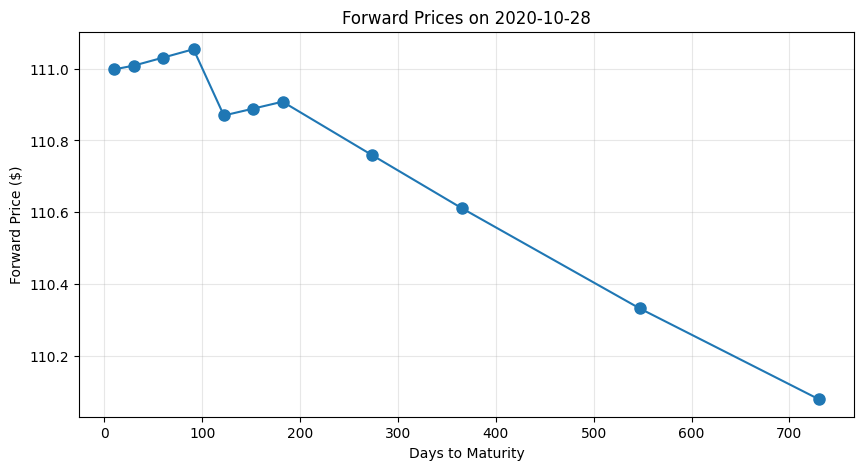

In [14]:
# Plot forward prices for a sample date across maturities
sample_date = stdop['date'].iloc[len(stdop)//2]  # Middle date
sample = stdop[stdop['date'] == sample_date].drop_duplicates(subset=['days'])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sample['days'], sample['forward_price'], 'o-', markersize=8)
ax.set_xlabel('Days to Maturity')
ax.set_ylabel('Forward Price ($)')
ax.set_title(f'Forward Prices on {str(sample_date)[:10]}')
ax.grid(True, alpha=0.3)
plt.show()

In [15]:
# Save std option price data
stdop_path = RAW_DIR / "std_option_price" / f"{TICKER}_stdopd_{START_DATE}_{END_DATE}.csv.gz"
stdop.to_csv(stdop_path, index=False, compression="gzip")
print(f"Saved std option prices to: {stdop_path}")

Saved std option prices to: ..\..\data\raw\ivydb\std_option_price\AAPL_stdopd_2016-01-01_2025-12-31.csv.gz


## 4. Summary

In [16]:
print("="*60)
print("SUMMARY")
print("="*60)
print(f"Ticker: {TICKER}")
print(f"SECID: {SECID}")
print(f"Date range: {START_DATE} to {END_DATE}")
print()
print(f"Zero curve:         {len(zc):,} rows")
print(f"  Saved to: {zc_path}")
print()
print(f"Std option prices:  {len(stdop):,} rows")
print(f"  Saved to: {stdop_path}")
print("="*60)

SUMMARY
Ticker: AAPL
SECID: 101594
Date range: 2016-01-01 to 2025-12-31

Zero curve:         77,707 rows
  Saved to: ..\..\data\raw\ivydb\zero_curve\zero_curve_2016-01-01_2025-12-31.csv.gz

Std option prices:  53,438 rows
  Saved to: ..\..\data\raw\ivydb\std_option_price\AAPL_stdopd_2016-01-01_2025-12-31.csv.gz


In [17]:
# Close WRDS connection
db.close()
print("WRDS connection closed.")

WRDS connection closed.
